In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from logreg import LogReg, evaluate_acc, minmax_normalization, zscore_normalization
from lda import kfold_index

In [3]:
import numpy as np
import csv
import pandas as pd
import os
import copy
import timeit

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 5)

In [5]:
# Datasets

In [6]:
cwd = os.getcwd()

df_wine = pd.read_csv(os.path.join(cwd, 'Data', 'winequality-red.csv'), delimiter=";")

In [12]:
# wine train and validation sets

df_wine['label'] = df_wine['quality'].apply(lambda x: 1 if x >= 6 and x <= 10 else 0)
cols = list(df_wine.columns)
cols.remove('quality')
wine_full_set = df_wine[cols].to_numpy()

train_perc = (0.0,1.0)
train1_perc = (0.0, 0.8)
dev_perc = (0.8, 1.0)
wine_full_set_len = len(wine_full_set)

wine_train_set = wine_full_set[int(train_perc[0]*wine_full_set_len):int(train_perc[1]*wine_full_set_len)]
wine_train1_set = wine_full_set[int(train1_perc[0]*wine_full_set_len):int(train1_perc[1]*wine_full_set_len)]
wine_val_set = wine_full_set[int(dev_perc[0]*wine_full_set_len):int(dev_perc[1]*wine_full_set_len)]

In [13]:
x_wine = wine_train_set[:,:-1]
y_wine = wine_train_set[:,-1:]

x_train1_wine = wine_train1_set[:,:-1]
y_train1_wine = wine_train1_set[:,-1:]

x_wine_val = wine_val_set[:,:-1]
y_wine_val = wine_val_set[:,-1:]

In [14]:
# breast cancer train and validation sets

df_bc = pd.read_csv(os.path.join(cwd, 'Data', 'breast-cancer-wisconsin.data'), header=None)
df_bc = df_bc.drop(columns=[0])

bc_col_names = ['clump_thickness', 'uniformity_of_cell_size',
               'uniformity_of_cell_shape', 'margincal_adhesion',
               'single_epithelial_cell_size', 'bare_nuclei',
               'bland_chromatin', 'normal_nucleoli', 'mitoses', 'class']

df_bc.columns = bc_col_names

for col in df_bc.columns:
    df_bc[col] = pd.to_numeric(df_bc[col], errors='coerce')

# make everything float64
df_bc = df_bc.astype('float64')

# all the ? are now np.nan's and filling those nans with mean of col
df_bc = df_bc.fillna(df_bc.mean())

df_bc['class'] = df_bc['class'].apply(lambda x: 0 if x == 2 else 1)

bc_full_set = df_bc[bc_col_names].to_numpy()

bc_train_perc = (0.0,1.0)
bc_train1_perc = (0.0, 0.8)
bc_dev_perc = (0.8, 1.0)
bc_full_set_len = len(bc_full_set)

bc_train_set = bc_full_set[int(bc_train_perc[0]*bc_full_set_len):int(bc_train_perc[1]*bc_full_set_len)]
bc_train1_set = bc_full_set[int(bc_train1_perc[0]*bc_full_set_len):int(bc_train1_perc[1]*bc_full_set_len)]
bc_val_set = bc_full_set[int(bc_dev_perc[0]*bc_full_set_len):int(bc_dev_perc[1]*bc_full_set_len)]

In [15]:
x_bc = bc_train_set[:,:-1]
y_bc = bc_train_set[:,-1:]

x_train1_bc = bc_train1_set[:,:-1]
y_train1_bc = bc_train1_set[:,-1:]

x_bc_val = bc_val_set[:,:-1]
y_bc_val = bc_val_set[:,-1:]

## Calling the logistic regression class

In [16]:
logreg = LogReg(learning_rate=0.01, iterations=1000)
logreg.fit(x_wine, y_wine)
y_pred = logreg.predict(x_wine_val)
print("accuracy:", evaluate_acc(y_wine_val, y_pred))

accuracy: 0.51875


### k fold check

In [18]:
kfold_acc = []
for train_index, test_index in kfold_index(5, x_wine):
    logreg = LogReg(learning_rate=0.01, iterations=1000)
    logreg.fit(x_wine[train_index], y_wine[train_index])
    y_pred = logreg.predict(x_wine[test_index])
    kfold_acc.append(evaluate_acc(y_wine[test_index], y_pred))
print("average k-fold accuracy:", np.mean(kfold_acc))

average k-fold accuracy: 0.567862460815047


## Experiment 1 - different learning rates + gradient descent stopping criteria

In [19]:
# trying many different learning rates

learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005]
lr_accuracies = {}


for lr in learning_rates:
    print('lr', lr)
    kfold_acc = []
    for train_index, test_index in kfold_index(5, x_wine):
        logreg = LogReg(learning_rate=lr, iterations=1000)
        logreg.fit(x_wine[train_index], y_wine[train_index])
        y_pred = logreg.predict(x_wine[test_index])
        kfold_acc.append(evaluate_acc(y_wine[test_index], y_pred))
    lr_accuracies[lr] = np.mean(kfold_acc)

lr_accuracies

lr 0.1
lr 0.05
lr 0.01
lr 0.005
lr 0.001
lr 0.0005


{0.1: 0.5678389498432602,
 0.05: 0.5684933385579937,
 0.01: 0.569092868338558,
 0.005: 0.5697237460815047,
 0.001: 0.5747296238244515,
 0.0005: 0.569757053291536}

In [20]:
# trying many different learning rates

learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005]
lr_accuracies = {}


for lr in learning_rates:
    print('lr', lr)
    kfold_acc = []
    for train_index, test_index in kfold_index(5, x_wine):
        logreg = LogReg(learning_rate=lr, iterations=10000)
        logreg.fit(x_wine[train_index], y_wine[train_index])
        y_pred = logreg.predict(x_wine[test_index])
        kfold_acc.append(evaluate_acc(y_wine[test_index], y_pred))
    lr_accuracies[lr] = np.mean(kfold_acc)

lr_accuracies

lr 0.1
lr 0.05
lr 0.01
lr 0.005
lr 0.001
lr 0.0005


{0.1: 0.5940987460815046,
 0.05: 0.583489420062696,
 0.01: 0.581594827586207,
 0.005: 0.5834815830721004,
 0.001: 0.6085011755485893,
 0.0005: 0.600364420062696}

In [21]:
# trying many different learning rates

learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005]
lr_accuracies = {}


for lr in learning_rates:
    print('lr', lr)
    kfold_acc = []
    for train_index, test_index in kfold_index(5, x_wine):
        logreg = LogReg(learning_rate=lr, iterations=100000)
        logreg.fit(x_wine[train_index], y_wine[train_index])
        y_pred = logreg.predict(x_wine[test_index])
        kfold_acc.append(evaluate_acc(y_wine[test_index], y_pred))
    lr_accuracies[lr] = np.mean(kfold_acc)

lr_accuracies

lr 0.1
lr 0.05
lr 0.01
lr 0.005
lr 0.001
lr 0.0005


{0.1: 0.639153605015674,
 0.05: 0.6241261755485893,
 0.01: 0.6210266457680251,
 0.005: 0.620401645768025,
 0.001: 0.6403781347962382,
 0.0005: 0.6291242163009405}

In [24]:
x_train1_wine

array([[ 7.4  ,  0.7  ,  0.   , ...,  3.51 ,  0.56 ,  9.4  ],
       [ 7.8  ,  0.88 ,  0.   , ...,  3.2  ,  0.68 ,  9.8  ],
       [ 7.8  ,  0.76 ,  0.04 , ...,  3.26 ,  0.65 ,  9.8  ],
       ...,
       [ 8.5  ,  0.4  ,  0.4  , ...,  3.28 ,  0.56 , 12.   ],
       [ 7.   ,  0.69 ,  0.   , ...,  3.35 ,  0.6  ,  9.7  ],
       [ 8.   ,  0.715,  0.22 , ...,  3.24 ,  0.54 ,  9.5  ]])

accuracy: 0.565625


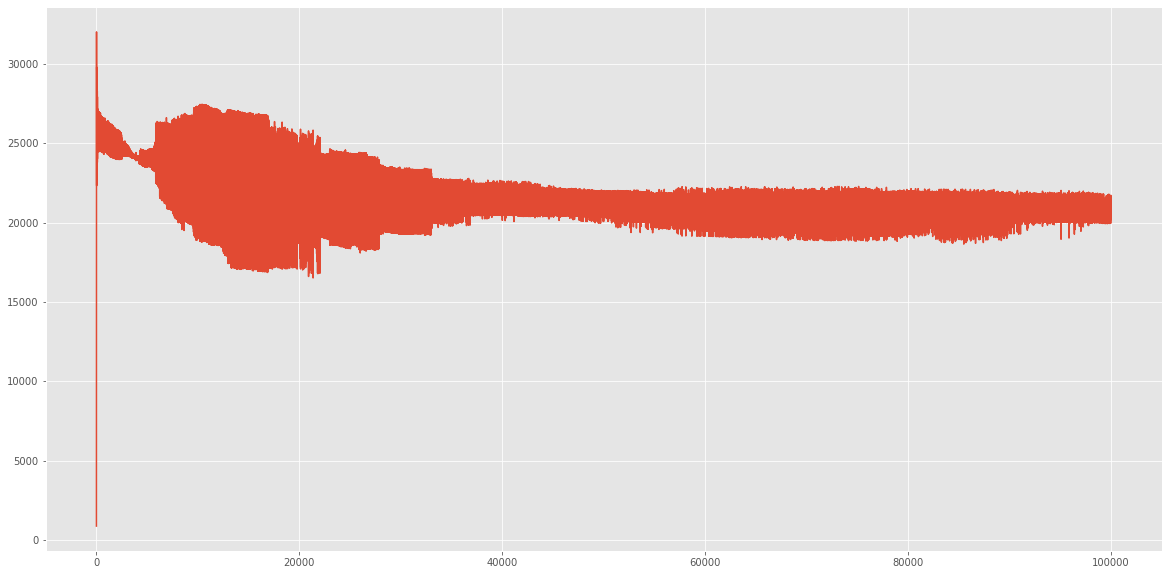

In [25]:
logreg = LogReg(learning_rate=0.01, iterations=100000)
logreg.fit(x_train1_wine, y_train1_wine)
y_pred = logreg.predict(x_wine_val)
print("accuracy:", evaluate_acc(y_wine_val, y_pred))

plt.figure(figsize=(20,10))
plt.plot(logreg.loss)

In [27]:
x_train1_wine_minmax = copy.deepcopy(x_train1_wine)
x_wine_val_minmax = copy.deepcopy(x_wine_val)

x_train1_wine_minmax = minmax_normalization(x_train1_wine_minmax)
x_wine_val_minmax = minmax_normalization(x_wine_val_minmax)

x_train1_wine_zscore = copy.deepcopy(x_train1_wine)
x_wine_val_zscore = copy.deepcopy(x_wine_val)

x_train1_wine_zscore = zscore_normalization(x_train1_wine_zscore)
x_wine_val_zscore = zscore_normalization(x_wine_val_zscore)

#####

x_wine_minmax = copy.deepcopy(x_wine)
x_wine_val_minmax = copy.deepcopy(x_wine_val)

x_wine_minmax = minmax_normalization(x_wine_minmax)
x_wine_val_minmax = minmax_normalization(x_wine_val_minmax)

x_wine_zscore = copy.deepcopy(x_wine)
x_wine_val_zscore = copy.deepcopy(x_wine_val)

x_wine_zscore = zscore_normalization(x_wine_zscore)
x_wine_val_zscore = zscore_normalization(x_wine_val_zscore)

In [28]:
learning_rate = 0.001
iterations = 1000

minmax accuracy: 0.66875
zscore accuracy: 0.734375


Text(0.5, 1.0, 'Zscore Loss')

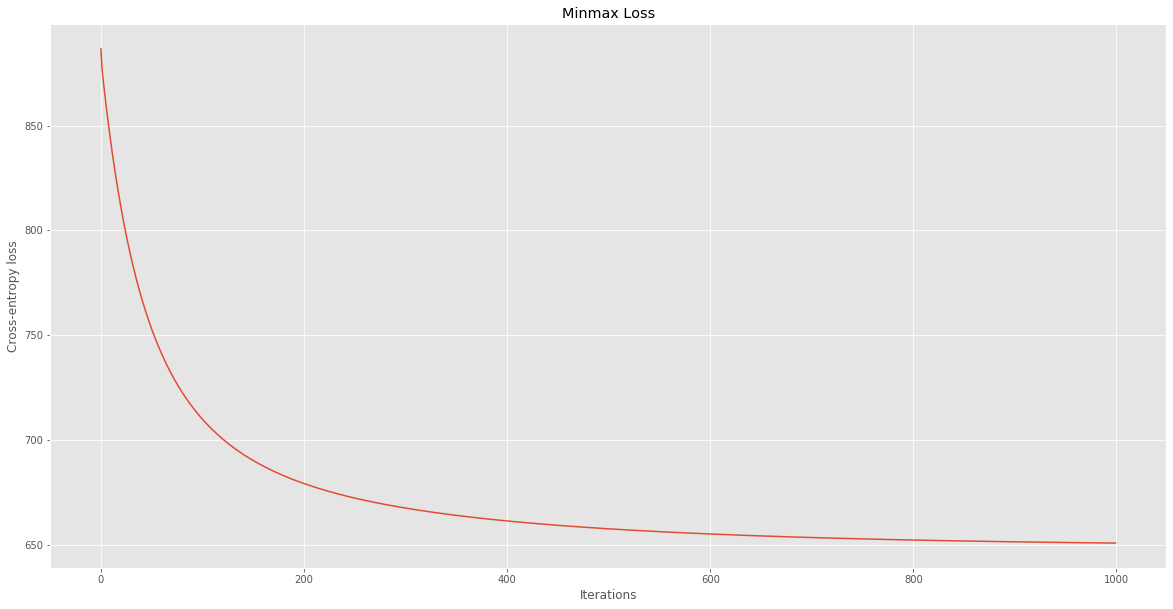

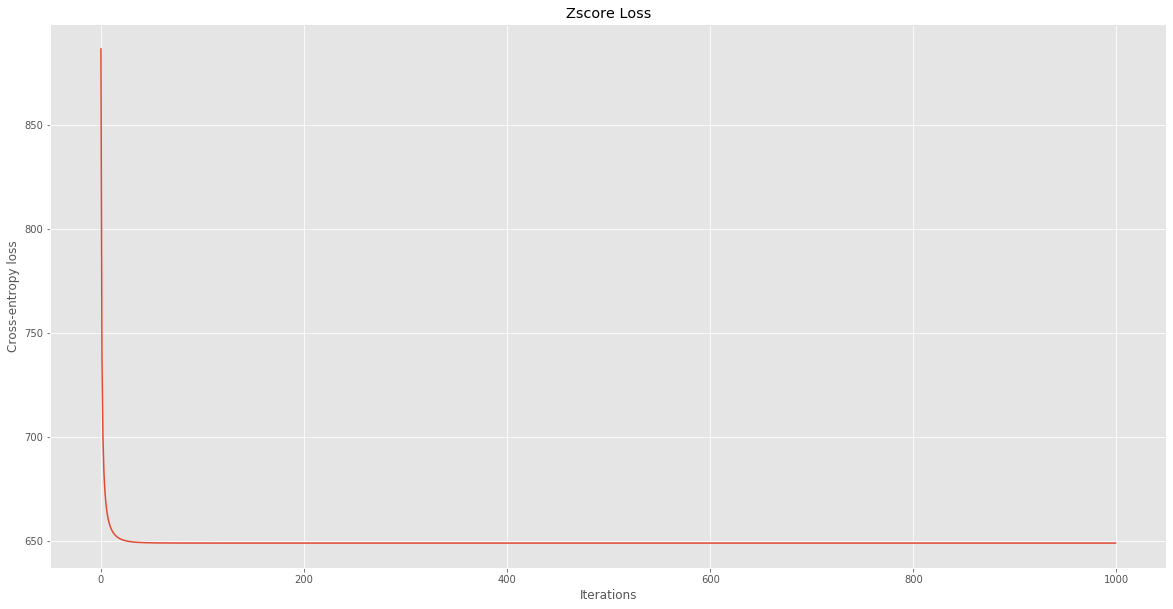

In [29]:
logreg = LogReg(learning_rate=learning_rate, iterations=iterations)
logreg.fit(x_train1_wine_minmax, y_train1_wine)
y_pred = logreg.predict(x_wine_val_minmax)
accuracy = evaluate_acc(y_pred, y_wine_val)
print("minmax accuracy:", accuracy)

plt.figure(figsize=(20,10))
plt.plot(logreg.loss)
plt.xlabel("Iterations")
plt.ylabel("Cross-entropy loss")
plt.title("Minmax Loss")

logreg = LogReg(learning_rate=learning_rate, iterations=iterations)
logreg.fit(x_train1_wine_zscore, y_train1_wine)
y_pred = logreg.predict(x_wine_val_zscore)
accuracy = evaluate_acc(y_pred, y_wine_val)
print("zscore accuracy:", accuracy)

plt.figure(figsize=(20,10))
plt.plot(logreg.loss)
plt.xlabel("Iterations")
plt.ylabel("Cross-entropy loss")
plt.title("Zscore Loss")

In [30]:
# learning rates using minmax noramlization

learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005]
lr_accuracies = {}

for lr in learning_rates:
    print('lr', lr)
    kfold_acc = []
    for train_index, test_index in kfold_index(5, x_wine):
        logreg = LogReg(learning_rate=lr, iterations=1000)
        logreg.fit(x_wine_minmax[train_index], y_wine[train_index])
        y_pred = logreg.predict(x_wine_minmax[test_index])
        kfold_acc.append(evaluate_acc(y_wine[test_index], y_pred))
    lr_accuracies[lr] = np.mean(kfold_acc)

lr_accuracies

lr 0.1
lr 0.05
lr 0.01
lr 0.005
lr 0.001
lr 0.0005


{0.1: 0.6497511755485894,
 0.05: 0.6497962382445142,
 0.01: 0.671671238244514,
 0.005: 0.7267045454545455,
 0.001: 0.7448667711598747,
 0.0005: 0.7398530564263324}

In [31]:
# learning rates using zscore noramlization. lowering iterations to 1000.

learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005]
lr_accuracies = {}

for lr in learning_rates:
    print('lr', lr)
    kfold_acc = []
    for train_index, test_index in kfold_index(5, x_wine):
        logreg = LogReg(learning_rate=lr, iterations=1000)
        logreg.fit(x_wine_zscore[train_index], y_wine[train_index])
        y_pred = logreg.predict(x_wine_zscore[test_index])
        kfold_acc.append(evaluate_acc(y_wine[test_index], y_pred))
    lr_accuracies[lr] = np.mean(kfold_acc)

lr_accuracies

lr 0.1
lr 0.05
lr 0.01
lr 0.005
lr 0.001
lr 0.0005


{0.1: 0.635401645768025,
 0.05: 0.6322590125391849,
 0.01: 0.6397707680250784,
 0.005: 0.6591751567398119,
 0.001: 0.7448706896551724,
 0.0005: 0.7398236677115988}

accuracy: 0.9857142857142858


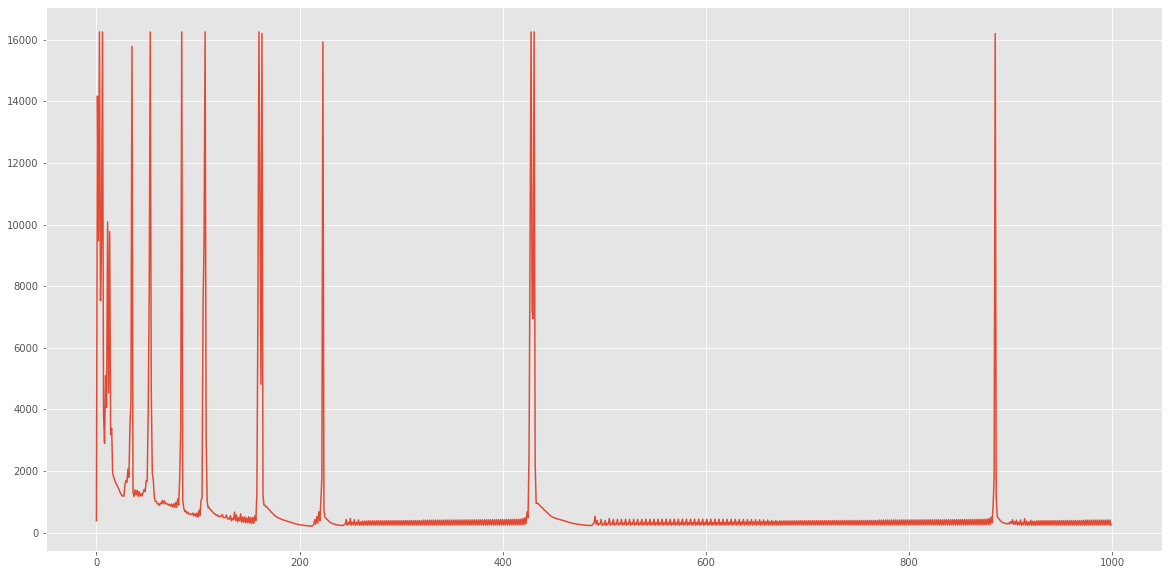

In [34]:
logreg = LogReg(learning_rate=0.01, iterations=1000)
logreg.fit(x_train1_bc, y_train1_bc)
y_pred = logreg.predict(x_bc_val)
print("accuracy:", evaluate_acc(y_bc_val, y_pred))

plt.figure(figsize=(20,10))
plt.plot(logreg.loss)

In [56]:
x_train1_bc_minmax = copy.deepcopy(x_train1_bc)
x_bc_val_minmax = copy.deepcopy(x_bc_val)

x_train1_bc_minmax = minmax_normalization(x_train1_bc_minmax)
x_bc_val_minmax = minmax_normalization(x_bc_val_minmax)

x_train1_bc_zscore = copy.deepcopy(x_train1_bc)
x_bc_val_zscore = copy.deepcopy(x_bc_val)

x_train1_bc_zscore = zscore_normalization(x_train1_bc_zscore)
x_bc_val_zscore = zscore_normalization(x_bc_val_zscore)

#####

x_bc_minmax = copy.deepcopy(x_bc)
x_bc_val_minmax = copy.deepcopy(x_bc_val)

x_bc_minmax = minmax_normalization(x_bc_minmax)
x_bc_val_minmax = minmax_normalization(x_bc_val_minmax)

x_bc_zscore = copy.deepcopy(x_bc)
x_bc_val_zscore = copy.deepcopy(x_bc_val)

x_bc_zscore = zscore_normalization(x_bc_zscore)
x_bc_val_zscore = zscore_normalization(x_bc_val_zscore)

minmax accuracy: 1.0
zscore accuracy: 0.9857142857142858


Text(0.5, 1.0, 'Zscore Loss')

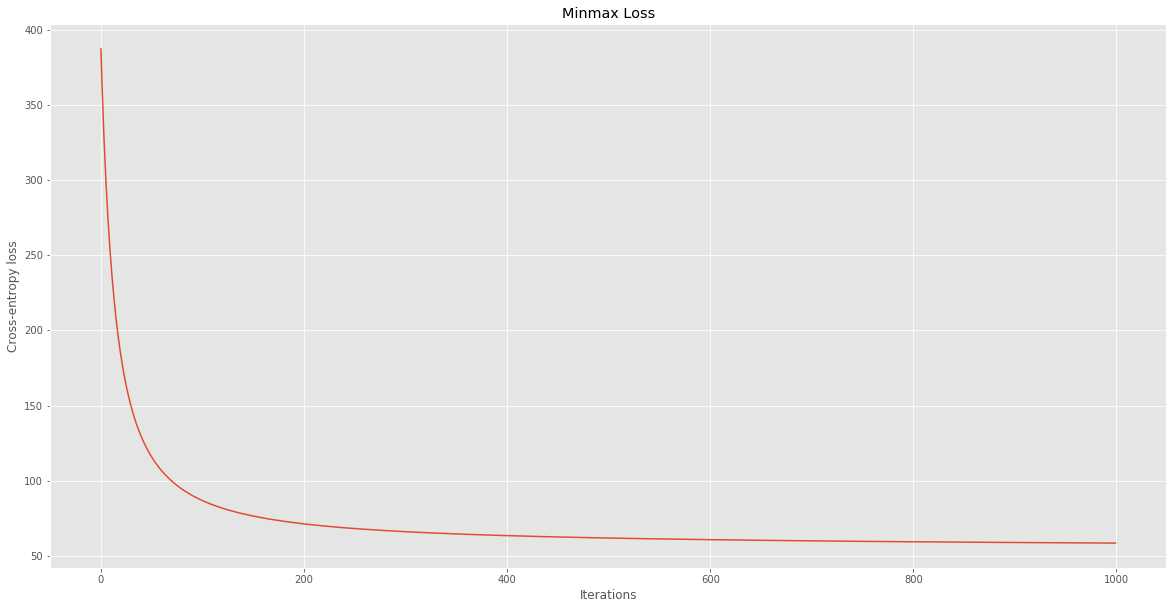

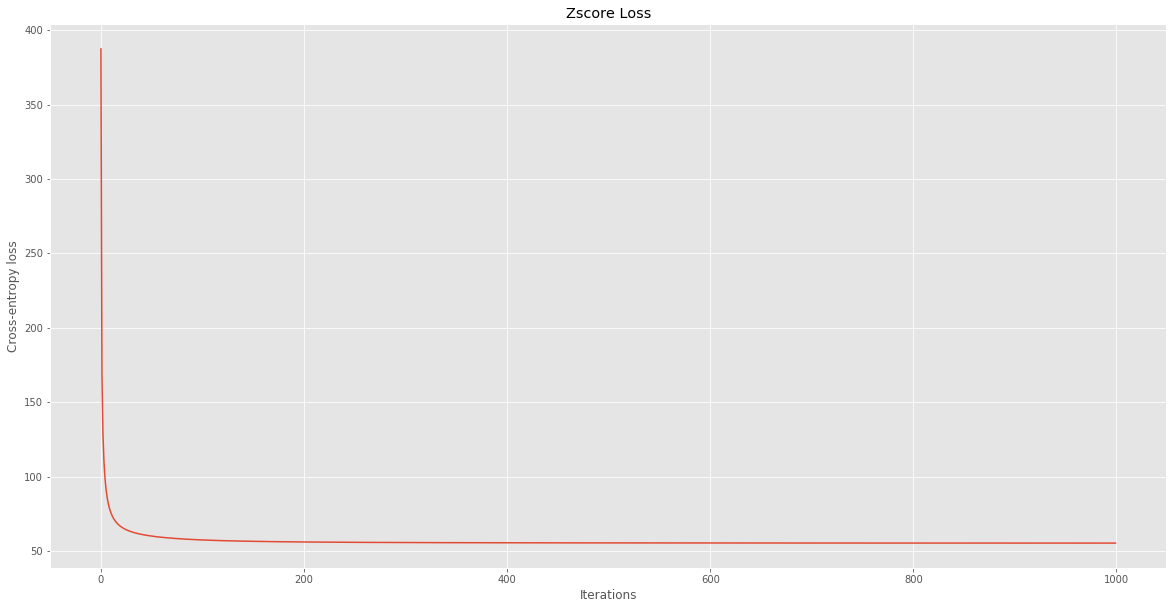

In [57]:
logreg = LogReg(learning_rate=learning_rate, iterations=iterations)
logreg.fit(x_train1_bc_minmax, y_train1_bc)
y_pred = logreg.predict(x_bc_val_minmax)
accuracy = evaluate_acc(y_pred, y_bc_val)
print("minmax accuracy:", accuracy)

plt.figure(figsize=(20,10))
plt.plot(logreg.loss)
plt.xlabel("Iterations")
plt.ylabel("Cross-entropy loss")
plt.title("Minmax Loss")

logreg = LogReg(learning_rate=learning_rate, iterations=iterations)
logreg.fit(x_train1_bc_zscore, y_train1_bc)
y_pred = logreg.predict(x_bc_val_zscore)
accuracy = evaluate_acc(y_pred, y_bc_val)
print("zscore accuracy:", accuracy)

plt.figure(figsize=(20,10))
plt.plot(logreg.loss)
plt.xlabel("Iterations")
plt.ylabel("Cross-entropy loss")
plt.title("Zscore Loss")

In [58]:
# learning rates using minmax noramlization

learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005]
lr_accuracies = {}

for lr in learning_rates:
    print('lr', lr)
    kfold_acc = []
    for train_index, test_index in kfold_index(5, x_bc):
        logreg = LogReg(learning_rate=lr, iterations=1000)
        logreg.fit(x_bc_minmax[train_index], y_bc[train_index])
        y_pred = logreg.predict(x_bc_minmax[test_index])
        kfold_acc.append(evaluate_acc(y_bc[test_index], y_pred))
    lr_accuracies[lr] = np.mean(kfold_acc)

lr_accuracies

lr 0.1
lr 0.05
lr 0.01
lr 0.005
lr 0.001
lr 0.0005


{0.1: 0.9642548818088386,
 0.05: 0.9656731757451181,
 0.01: 0.96568345323741,
 0.005: 0.9627852004110997,
 0.001: 0.9656628982528265,
 0.0005: 0.9628365878725591}

In [62]:
# learning rates using zscore noramlization. lowering iterations to 1000.

learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005]
lr_accuracies = {}

for lr in learning_rates:
    print('lr', lr)
    kfold_acc = []
    for train_index, test_index in kfold_index(5, x_bc):
        logreg = LogReg(learning_rate=lr, iterations=1000)
        logreg.fit(x_bc_zscore[train_index], y_bc[train_index])
        y_pred = logreg.predict(x_bc_zscore[test_index])
        kfold_acc.append(evaluate_acc(y_bc[test_index], y_pred))
    lr_accuracies[lr] = np.mean(kfold_acc)

lr_accuracies

lr 0.1
lr 0.05
lr 0.01
lr 0.005
lr 0.001
lr 0.0005


{0.1: 0.9642343268242548,
 0.05: 0.9656526207605346,
 0.01: 0.9656628982528263,
 0.005: 0.9642240493319629,
 0.001: 0.9628160328879755,
 0.0005: 0.9670503597122302}

In [63]:
learning_rate = 0.001
iterations = 1000

## Experiment 1 - Runtime and accuracy

In [64]:
# Runtime for wine dataset

execution_time = []

for train_index, test_index in kfold_index(5, x_wine):
    start = timeit.default_timer()
    
    logreg = LogReg(learning_rate=lr, iterations=1000)
    logreg.fit(x_wine_minmax[train_index], y_wine[train_index])
    y_pred = logreg.predict(x_wine_minmax[test_index])
    
    stop = timeit.default_timer()
    etime = stop - start
    execution_time.append(etime)
    
print("average runtime: {} seconds".format(np.mean(execution_time)))

average runtime: 0.0850019405974308 seconds


In [65]:
# Runtime for breast cancer dataset

execution_time = []

for train_index, test_index in kfold_index(5, x_bc):
    start = timeit.default_timer()
    
    logreg = LogReg(learning_rate=lr, iterations=1000)
    logreg.fit(x_bc_minmax[train_index], y_bc[train_index])
    y_pred = logreg.predict(x_bc_minmax[test_index])
    
    stop = timeit.default_timer()
    etime = stop - start
    execution_time.append(etime)
    
print("average runtime: {} seconds".format(np.mean(execution_time)))

average runtime: 0.05895054620341398 seconds


In [70]:
# accuracy for wine dataset

kfold_acc = []

for train_index, test_index in kfold_index(5, x_wine):
    start = timeit.default_timer()
    
    logreg = LogReg(learning_rate=lr, iterations=1000)
    logreg.fit(x_wine_minmax[train_index], y_wine[train_index])
    y_pred = logreg.predict(x_wine_minmax[test_index])
    kfold_acc.append(evaluate_acc(y_wine[test_index], y_pred))
    
print("average accuracy: {}".format(np.mean(kfold_acc)))

average accuracy: 0.74546434169279


In [73]:
# accuracy for breast cancer dataset

kfold_acc = []

for train_index, test_index in kfold_index(5, x_bc):
    start = timeit.default_timer()
    
    logreg = LogReg(learning_rate=lr, iterations=1000)
    logreg.fit(x_bc_minmax[train_index], y_bc[train_index])
    y_pred = logreg.predict(x_bc_minmax[test_index])
    kfold_acc.append(evaluate_acc(y_bc[test_index], y_pred))
    
print("average accuracy: {}".format(np.mean(kfold_acc)))

average accuracy: 0.9642548818088386


## Experiment 3 - Wine dataset features

In [74]:
df_wine.corr()['label'].drop(['label', 'quality'])

fixed acidity           0.095093
volatile acidity       -0.321441
citric acid             0.159129
residual sugar         -0.002160
chlorides              -0.109494
free sulfur dioxide    -0.061757
total sulfur dioxide   -0.231963
density                -0.159110
pH                     -0.003264
sulphates               0.218072
alcohol                 0.434751
Name: label, dtype: float64

In [75]:
wine_corr_cols = [0, 2, 9, 10]

In [76]:
x_wine_corr = wine_train_set[:,wine_corr_cols]
y_wine = wine_train_set[:,-1:]

x_wine_corr_minmax = copy.deepcopy(x_wine_corr)
x_wine_corr_minmax = minmax_normalization(x_wine_corr_minmax)

In [77]:
# accuracy for wine dataset

kfold_acc = []

for train_index, test_index in kfold_index(5, x_wine):
    start = timeit.default_timer()
    
    logreg = LogReg(learning_rate=lr, iterations=1000)
    logreg.fit(x_wine_corr_minmax[train_index], y_wine[train_index])
    y_pred = logreg.predict(x_wine_corr_minmax[test_index])
    kfold_acc.append(evaluate_acc(y_wine[test_index], y_pred))
    
print("average accuracy: {}".format(np.mean(kfold_acc)))

average accuracy: 0.7079604231974922


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a214c6208>,
      dtype=object)

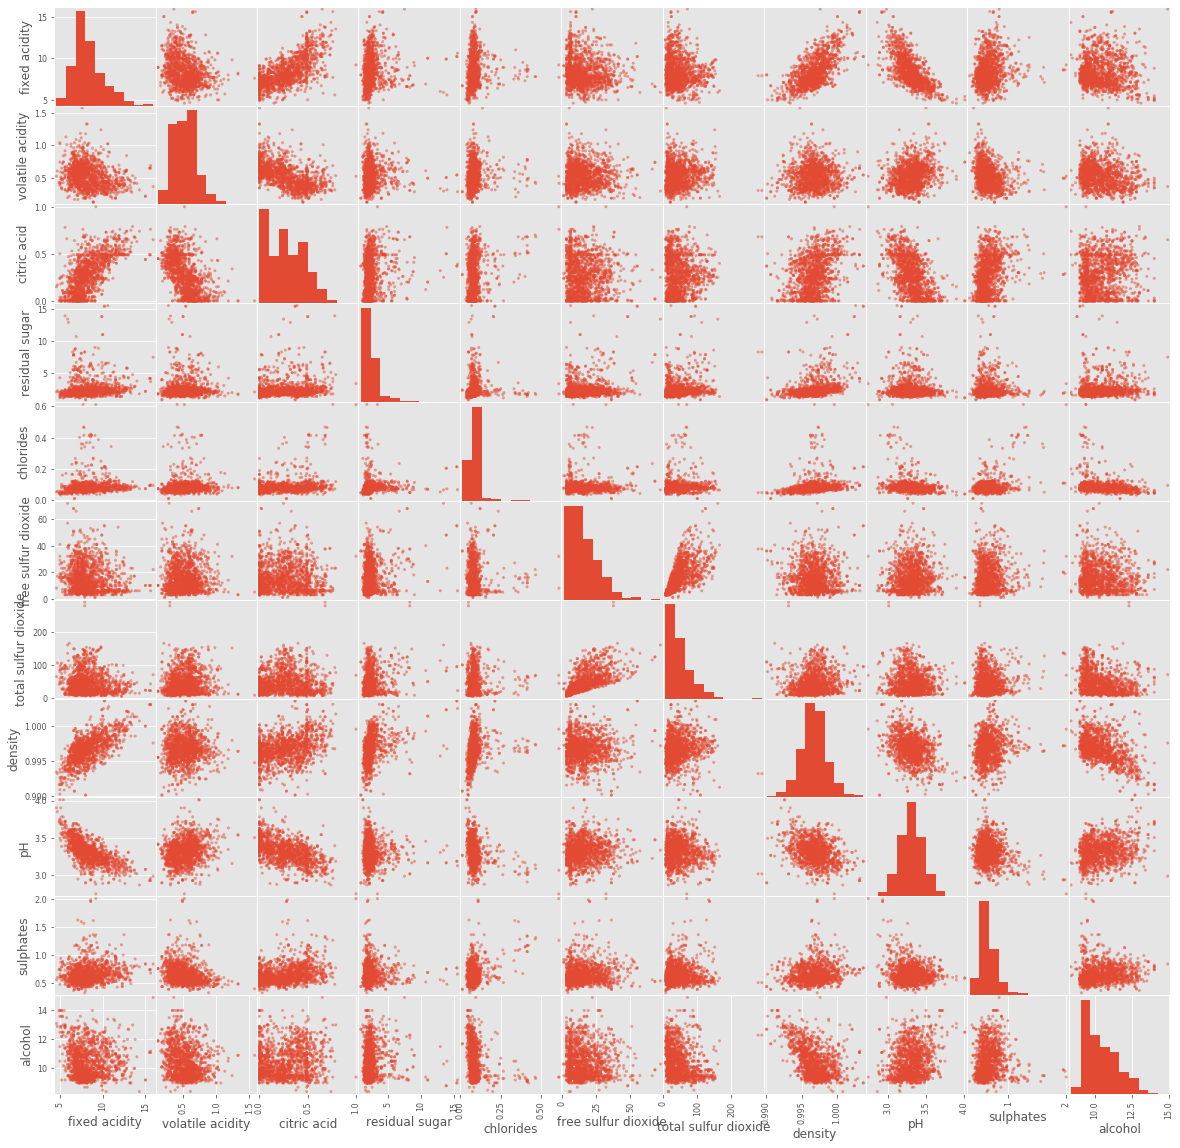

In [78]:
pd.plotting.scatter_matrix(df_wine.drop(columns=['quality', 'label']), figsize=(20,20))

In [79]:
x_wine_inter = wine_train_set[:,:-1]

# fixed_acidity/density is columns 0 and 7
x_wine_inter_1 = x_wine_inter[:,0] * x_wine_inter[:,7]

# fixed_acidity/citric_acid is columns 0 and 2
x_wine_inter_2 = x_wine_inter[:,0] * x_wine_inter[:,2]

# total_sulfur_dioxide/free_sulfur_dioxide is columns 5 and 6
x_wine_inter_3 = x_wine_inter[:,5] * x_wine_inter[:,6]

x_wine_inter = np.c_[x_wine_inter, x_wine_inter_1, x_wine_inter_2, x_wine_inter_3]

x_wine_inter_minmax = copy.deepcopy(x_wine_inter)
x_wine_inter_minmax = minmax_normalization(x_wine_inter_minmax)

In [80]:
# accuracy for wine dataset

kfold_acc = []

for train_index, test_index in kfold_index(5, x_wine):
    start = timeit.default_timer()
    
    logreg = LogReg(learning_rate=lr, iterations=1000)
    logreg.fit(x_wine_inter_minmax[train_index], y_wine[train_index])
    y_pred = logreg.predict(x_wine_inter_minmax[test_index])
    kfold_acc.append(evaluate_acc(y_wine[test_index], y_pred))
    
print("average accuracy: {}".format(np.mean(kfold_acc)))

average accuracy: 0.7404467084639498


## Experiment 3a - breast cancer features

In [81]:
df_bc.corr()['class'].drop(['class'])

clump_thickness                0.716001
uniformity_of_cell_size        0.817904
uniformity_of_cell_shape       0.818934
margincal_adhesion             0.696800
single_epithelial_cell_size    0.682785
bare_nuclei                    0.816050
bland_chromatin                0.756616
normal_nucleoli                0.712244
mitoses                        0.423170
Name: class, dtype: float64

In [82]:
x_bc_inter = bc_train_set[:,:-1]

# fixed_acidity/density is columns 1 and 2
x_bc_inter_1 = x_bc_inter[:,1] * x_bc_inter[:,2]

x_bc_inter = np.c_[x_bc_inter, x_bc_inter_1]

x_bc_inter_minmax = copy.deepcopy(x_bc_inter)
x_bc_inter_minmax = minmax_normalization(x_bc_inter_minmax)

In [84]:
# accuracy for wine dataset

kfold_acc = []

for train_index, test_index in kfold_index(5, x_bc):
    start = timeit.default_timer()
    
    logreg = LogReg(learning_rate=lr, iterations=1000)
    logreg.fit(x_bc_inter_minmax[train_index], y_bc[train_index])
    y_pred = logreg.predict(x_bc_inter_minmax[test_index])
    kfold_acc.append(evaluate_acc(y_bc[test_index], y_pred))
    
print("average accuracy: {}".format(np.mean(kfold_acc)))

average accuracy: 0.962774922918808
